In [ ]:
## Étape 1 : Initialisation et Importations

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

import os
import zipfile
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from google.colab import drive

drive.mount('/content/drive')

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1
BATCH_SIZE = 16

fichier_zip = '/content/drive/MyDrive/archive (2).zip'
destination = '/content/data'

print("Décompression des données...")
os.makedirs(destination, exist_ok=True)
with zipfile.ZipFile(fichier_zip, 'r') as zip_ref:
    zip_ref.extractall(destination)

DATASET_PATH = '/content/data/Dataset_BUSI_with_GT/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Décompression des données...
Environnement prêt.


In [ ]:
def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input_tensor)
    x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    return x

def build_unet_model(input_shape=(128, 128, 1)):

    inputs = Input(input_shape)

    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)

    c_bottom = conv_block(p3, 512)

    u4 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c_bottom)
    u4 = concatenate([u4, c3])
    c4 = conv_block(u4, 256)

    u5 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c2])
    c5 = conv_block(u5, 128)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c1])
    c6 = conv_block(u6, 64)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c6)
    model = Model(inputs=[inputs], outputs=[outputs], name="UNet-BUSI")
    return model

print("Vérification de l'architecture U-Net :")
model_check = build_unet_model((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model_check.summary()

Vérification de l'architecture U-Net :


Model: "UNet-BUSI"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_60[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ conv2d_61[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_62[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 32, 32,    │          0 │ conv2d_63[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_64[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 16, 16,    │          0 │ conv2d_65[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_14… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_66[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_12 │ (None, 32, 32,    │    524,544 │ conv2d_67[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_65[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 32, 32,    │  1,179,904 │ concatenate_12[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_68[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_13 │ (None, 64, 64,    │    131,200 │ conv2d_69[0][0] 

 Total params: 7,696,193 (29.36 MB)

 Trainable params: 7,696,193 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def load_data_busi(dataset_path, img_height, img_width, img_channels):

    categories = [os.path.join(dataset_path, cat) for cat in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, cat))]
    X_data = []
    Y_data = []
    print(f"Chargement des données depuis : {dataset_path}")

    for category_path in categories:
        all_files = glob.glob(os.path.join(category_path, "*.png"))
        mask_files = [f for f in all_files if '_mask' in f]
        image_files = [f for f in all_files if '_mask' not in f]

        for img_path in tqdm(image_files, desc=f"Dossier {os.path.basename(category_path)}"):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_width, img_height))
            img = img / 255.0
            X_data.append(img)

            mask_path_expected = img_path.replace('.png', '_mask.png')
            if mask_path_expected in mask_files:
                mask = cv2.imread(mask_path_expected, cv2.IMREAD_GRAYSCALE)
            else:
                mask = np.zeros((img_height, img_width))

            mask = cv2.resize(mask, (img_width, img_height))
            mask = mask / 255.0
            mask[mask > 0.5] = 1.0
            mask[mask <= 0.5] = 0.0
            Y_data.append(mask)

    X_data = np.array(X_data)
    Y_data = np.array(Y_data)
    X_data = np.expand_dims(X_data, axis=-1)
    Y_data = np.expand_dims(Y_data, axis=-1)

    return X_data, Y_data

X_data, Y_data = load_data_busi(DATASET_PATH, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(f"Chargement terminé. Forme de X: {X_data.shape}, Forme de Y: {Y_data.shape}")

from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data,
                                                  test_size=0.1,
                                                  random_state=42)

print(f"Données divisées : {len(X_train)} entraînement, {len(X_val)} validation.")

Chargement des données depuis : /content/data/Dataset_BUSI_with_GT/


Dossier benign: 100%|██████████| 437/437 [00:04<00:00, 108.21it/s]


Chargement terminé. Forme de X: (780, 128, 128, 1), Forme de Y: (780, 128, 128, 1)
Données divisées : 702 entraînement, 78 validation.


In [ ]:
print("Entraînement du modèle de RÉFÉRENCE...")
model_base = build_unet_model((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model_base.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
history_base = model_base.fit(
    X_train, Y_train,
    batch_size=BATCH_SIZE,
    epochs=50,
    validation_data=(X_val, Y_val)
)
model_base.save('unet_busi_model_base.h5')
print("Modèle de référence sauvegardé.")

Entraînement du modèle de RÉFÉRENCE...
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 316ms/step - accuracy: 0.8543 - loss: 0.3627 - val_accuracy: 0.9264 - val_loss: 0.2603
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.9210 - loss: 0.2757 - val_accuracy: 0.9263 - val_loss: 0.2595
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.9201 - loss: 0.2644 - val_accuracy: 0.9264 - val_loss: 0.2132
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.9209 - loss: 0.2239 - val_accuracy: 0.9268 - val_loss: 0.1990
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.9225 - loss: 0.2042 - val_accuracy: 0.9346 - val_loss: 0.1930
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.9336 - loss: 0.1901 - val_accuracy: 0.9339 - val_loss: 0.1910
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.9314 - loss: 0.1946 - val_accuracy: 0.9355 - val_loss: 0.1784
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - accuracy: 

Modèle de référence sauvegardé.


In [ ]:
print("Mise en place de l'augmentation de données...")
data_gen_args = dict(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
seed = 1
image_generator = image_datagen.flow(X_train, batch_size=BATCH_SIZE, seed=seed)
mask_generator = mask_datagen.flow(Y_train, batch_size=BATCH_SIZE, seed=seed)
def create_zip_generator(gen1, gen2):
    while True:
        yield (next(gen1), next(gen2))

train_generator = create_zip_generator(image_generator, mask_generator)
model_aug = build_unet_model((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model_aug.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

print("Entraînement du modèle OPTIMISÉ (avec augmentation)...")
steps_per_epoch = len(X_train) // BATCH_SIZE

history_aug = model_aug.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=(X_val, Y_val)
)

model_aug.save('unet_busi_model_aug.h5')
print("Modèle optimisé sauvegardé.")

Mise en place de l'augmentation de données...
Entraînement du modèle OPTIMISÉ (avec augmentation)...
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step - accuracy: 0.8514 - loss: 0.3705 - val_accuracy: 0.9264 - val_loss: 0.2555
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 169ms/step - accuracy: 0.9117 - loss: 0.2881 - val_accuracy: 0.9264 - val_loss: 0.2743
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.9205 - loss: 0.2652 - val_accuracy: 0.9264 - val_loss: 0.2091
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.9225 - loss: 0.2400 - val_accuracy: 0.9295 - val_loss: 0.2032
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - accuracy: 0.9185 - loss: 0.2243 - val_accuracy: 0.9360 - val_loss: 0.1860
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.9193 - loss: 0.2101 - val_accuracy: 0.9360 - val_loss: 0.1799
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.9321 - loss: 0.1847 - val_accuracy: 0.9369 - val_loss: 0.1797
E

Modèle optimisé sauvegardé.


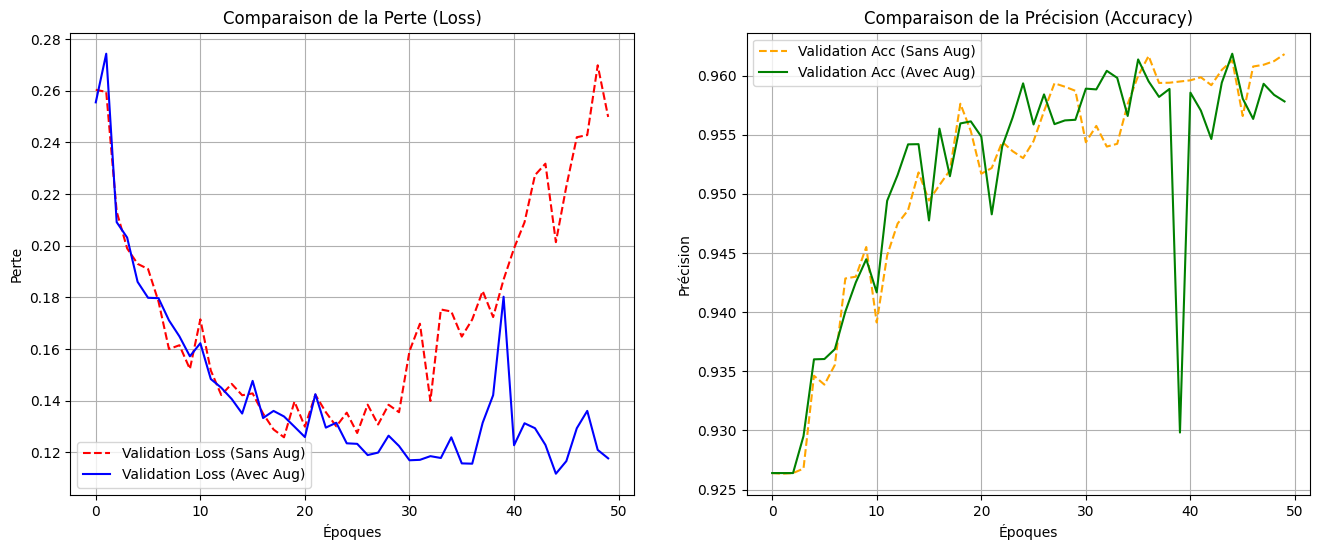

Prédiction avec les deux modèles...
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 485ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 406ms/step
Affichage des comparaisons visuelles...


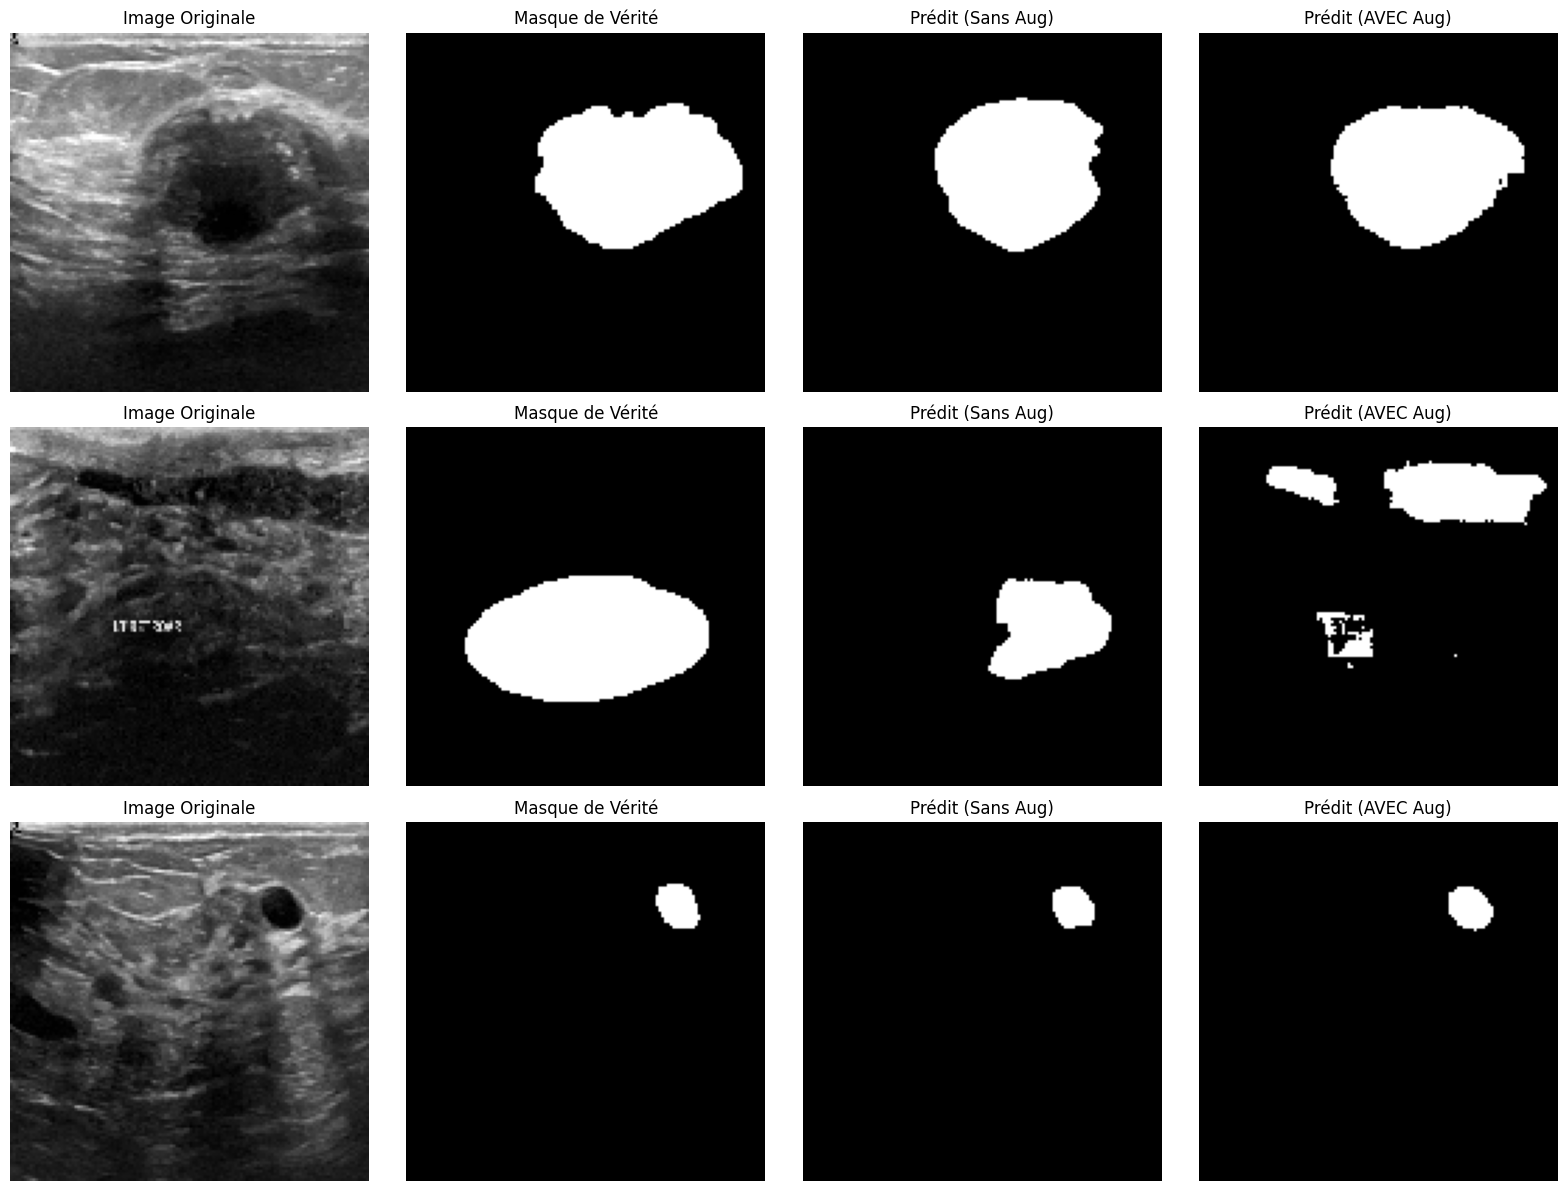

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title('Comparaison de la Perte (Loss)')
plt.plot(history_base.history['val_loss'], label='Validation Loss (Sans Aug)', color='red', linestyle='--')
plt.plot(history_aug.history['val_loss'], label='Validation Loss (Avec Aug)', color='blue')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Comparaison de la Précision (Accuracy)')
plt.plot(history_base.history['val_accuracy'], label='Validation Acc (Sans Aug)', color='orange', linestyle='--')
plt.plot(history_aug.history['val_accuracy'], label='Validation Acc (Avec Aug)', color='green')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.grid(True)
plt.show()
print("Prédiction avec les deux modèles...")
Y_pred_base = model_base.predict(X_val)
Y_pred_aug = model_aug.predict(X_val)
print("Affichage des comparaisons visuelles...")
num_images_a_voir = 3
indices_aleatoires = random.sample(range(len(X_val)), num_images_a_voir)

plt.figure(figsize=(16, num_images_a_voir * 4))

for i, index in enumerate(indices_aleatoires):
    img_originale = X_val[index]
    masque_vrai = Y_val[index]
    masque_predit_base = (Y_pred_base[index] > 0.5).astype(np.uint8)
    masque_predit_aug = (Y_pred_aug[index] > 0.5).astype(np.uint8)

    plt.subplot(num_images_a_voir, 4, i*4 + 1)
    plt.title("Image Originale")
    plt.imshow(img_originale.squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(num_images_a_voir, 4, i*4 + 2)
    plt.title("Masque de Vérité")
    plt.imshow(masque_vrai.squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(num_images_a_voir, 4, i*4 + 3)
    plt.title("Prédit (Sans Aug)")
    plt.imshow(masque_predit_base.squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(num_images_a_voir, 4, i*4 + 4)
    plt.title("Prédit (AVEC Aug)")
    plt.imshow(masque_predit_aug.squeeze(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

Veuillez choisir une image d'échographie à téléverser...


Saving images.jpeg to images (1).jpeg
Traitement de l'image : images (1).jpeg...
Chargement du modèle 'unet_busi_model_aug.h5'...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
Affichage du résultat !


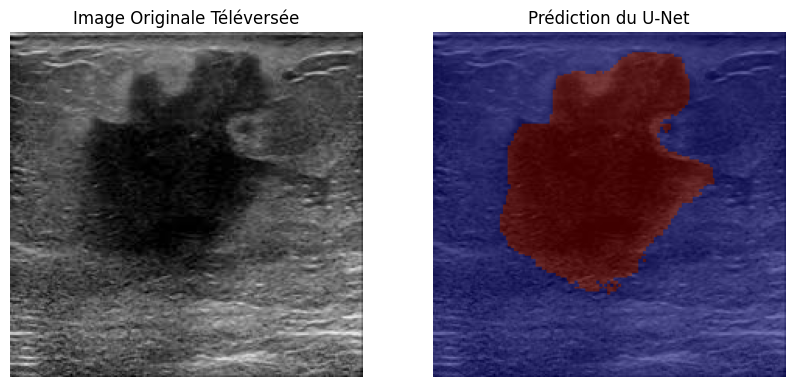

In [ ]:
from google.colab import files
print("Veuillez choisir une image d'échographie à téléverser...")
uploaded = files.upload()
if len(uploaded) > 0:
    img_name = list(uploaded.keys())[0]
    print(f"Traitement de l'image : {img_name}...")

    img_originale = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
    img_display = cv2.cvtColor(img_originale, cv2.COLOR_GRAY2RGB)
    h_orig, w_orig = img_originale.shape

    img_resized = cv2.resize(img_originale, (IMG_WIDTH, IMG_HEIGHT))
    img_norm = img_resized / 255.0
    img_batch = np.expand_dims(img_norm, axis=0)
    img_batch = np.expand_dims(img_batch, axis=-1)

    print("Chargement du modèle 'unet_busi_model_aug.h5'...")
    model = load_model('unet_busi_model_aug.h5')
    prediction_brute = model.predict(img_batch)

    masque_predit_128 = (prediction_brute[0].squeeze() > 0.5).astype(np.uint8)
    masque_predit_final = cv2.resize(masque_predit_128, (w_orig, h_orig),
                                     interpolation=cv2.INTER_NEAREST)

    print("Affichage du résultat !")
    plt.figure(figsize=(10, 7))
    plt.subplot(1, 2, 1)
    plt.title("Image Originale Téléversée")
    plt.imshow(img_display)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Prédiction du U-Net")
    plt.imshow(img_display)
    plt.imshow(masque_predit_final, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.show()
else:
    print("Aucun fichier n'a été téléversé.")